In [1]:
import numpy as np
import time
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
Bernoulli = tf.contrib.distributions.Bernoulli

data = input_data.read_data_sets("MNIST_data/", one_hot=True).test
data.images[data.images>0.5] = 1.0
data.images[data.images<=0.5] = 0.0

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Utilitiy functions

In [2]:
def plot_banded_error(errs, label, ax=None):
    ax = ax or plt
    m = np.mean(errs, axis=0)
    s = np.std(errs, axis=0)
    line, = ax.plot(np.arange(1, len(m)+1), m, '.-', label=label)

def fatlegend(ax, *a, **kw):
    leg = ax.legend(*a, **kw)
    for l in leg.legendHandles:
        l.set_linewidth(l.get_linewidth()*2.0)
    return leg

def stc_pass(inputs, layer, n):
    if layer==1:
        z = add_layer(inputs, "whh", "bhh", 100, 100, tf.nn.sigmoid)
        inputs = tf.reshape(Bernoulli(probs=z,dtype=tf.float32).sample(n), [n*n*batch_size,100])
    z = add_layer(inputs, "why", "bhy", 100, 392, tf.nn.sigmoid)
    z = tf.reduce_mean(tf.reshape(z,[n,n*batch_size,392]), 0) if layer==1 else z
    z = prob(z, tf.tile(y_,[n,1]))
    z_expect = tf.reduce_mean(tf.reshape(z, [n,batch_size,392]), 0)
    return tf.reduce_sum(z/tf.stop_gradient(tf.tile(-z_expect-eps, [n,1])), 1, keep_dims=True), z_expect

def fg_cov(f, g, w, n):
    f, g = [tf.reshape(z, [n,batch_size,100]) for z in [f,g]]
    for i in range(n):
        df, dg = [tf.concat(tf.gradients(tf.reduce_mean(z[i], 0), w), 0) for z in [f, g]]
        mf, mg = [df, dg] if i==0 else [mf+df, mg+dg]
        vg = tf.square(dg) if i==0 else vg+tf.square(dg)
        cov = df*dg if i==0 else cov+df*dg
    return mf/n, mg/n, (cov-mf*mg/n)/(n-1), (vg-tf.square(mg)/n)/(n-1)

def gd_stats(p, s, f, g, mg, dh, w):
    mdf, mdg = [tf.concat(tf.gradients(tf.reduce_mean(z,0), w), 0) for z in [f, g]]
    mgd = tf.concat([dh[0][0], dh[1][0]], 0)
    
    f, g, s = [tf.reshape(z, [ns, batch_size, 100]) for z in [f, g, s]]
    for i in range(ns):
        df, dg = [tf.concat(tf.gradients(tf.reduce_mean(z, 0), w), 0) for z in [f[i], g[i]]]
        vf = tf.square(df-mdf) if i==0 else vf+tf.square(df-mdf)
        vg = tf.square(dg-mdg) if i==0 else vg+tf.square(dg-mdg)        
        cov = (df-mdf)*(dg-mdg) if i==0 else cov+(df-mdf)*(dg-mdg)
        gd = tf.concat(tf.gradients(tf.reduce_mean(f[i]-g[i]+mg, 0), w), 0)
        vgd = tf.square(gd-mgd) if i==0 else vgd+tf.square(gd-mgd)    
    vf, vg, cov, vgd = [tf.reduce_sum(z)/(ns-1) for z in [vf, vg, cov, vgd]]
    return vf+vg-2*cov, vgd


### Parameters

In [3]:
batch_size = 4
lr = 1e-3
eps = 1e-7
alpha = 0.9
linear = True

### Graph

In [132]:
def get_weights(wn):
    with tf.variable_scope(tf.get_variable_scope(), reuse=True):
        return tf.get_variable(wn)

def add_layer(inputs, wn, in_dim, out_dim, af=None):
    try:
        w = tf.get_variable(wn, [(in_dim+1)*out_dim], initializer=tf.truncated_normal_initializer)
    except:
        with tf.variable_scope(tf.get_variable_scope(), reuse=True):
            w = tf.get_variable(wn)
    inputs = tf.concat([inputs, tf.ones([tf.shape(inputs)[0],1])], 1)
    ww = tf.transpose(tf.reshape(w,[out_dim, 1+in_dim]))
    return tf.matmul(inputs, ww) if af is None else af(tf.matmul(inputs, ww))

prob = lambda p, s: tf.pow(p+eps,s)*tf.pow(1-p+eps,1-s)
log_prob = lambda p, s: tf.log(prob(p, s))


ns = tf.placeholder(tf.int32)
x = tf.placeholder(tf.float32, [None, 392])
h = add_layer(x, "wxh", 392, 100, tf.nn.sigmoid)
sh = tf.stop_gradient(tf.reshape(Bernoulli(probs=h, dtype=tf.float32).sample(ns), [-1,100]))
h2 = add_layer(sh, "whh", 100, 100, tf.nn.sigmoid)
sh2 = tf.stop_gradient(tf.reshape(Bernoulli(probs=h2, dtype=tf.float32).sample(ns), [-1,100]))
y = add_layer(sh2, "why", 100, 392, tf.nn.sigmoid)
y_expect = tf.reduce_mean(tf.reshape(y, [ns**2, -1, 392]), 0)
y_ = tf.placeholder(tf.float32, [None, 392])


nll = tf.reduce_mean(tf.reduce_sum(-log_prob(y_expect, y_), 1))
ls2 = tf.reduce_sum(prob(y, tf.tile(y_,[ns**2,1]))/
                    tf.stop_gradient(tf.tile(-prob(y_expect, y_), [ns**2,1])), 1, keep_dims=True)
ls  = tf.reduce_mean(tf.reshape(ls2, [ns,-1,1]), 0)
_h, _h2 = [tf.tile(z, [ns, 1]) for z in [h, h2]]


opt = tf.train.GradientDescentOptimizer(lr)
dy = opt.compute_gradients(nll, get_weights("why"))    
dh2 = opt.compute_gradients(tf.reduce_mean(tf.stop_gradient(ls2)*log_prob(_h2, sh2), 0), 
                            get_weights("whh"))        
dh  = opt.compute_gradients(tf.reduce_mean(tf.stop_gradient(ls)*log_prob(_h, sh), 0),
                            get_weights("wxh"))
gd = [list(i) for i in dy]+[list(i) for i in dh2]+[list(i) for i in dh]
train_step = opt.apply_gradients(gd)

### NGD DPR1

In [179]:
djx = tf.placeholder(tf.float32,[3,100,393])
djh = tf.placeholder(tf.float32,[3,100,101])
djy = tf.placeholder(tf.float32,[3,392,101])
ts  = tf.placeholder(tf.float32)

beta = .999
alpha = .9

ngd = [list(i) for i in dh]+[list(i) for i in dh2]+[list(i) for i in dy]
layer = [[log_prob(h,sh), "wxh",[100,393],  dh[0][0],0,djx],
        [log_prob(h2,sh2), "whh",[100,101], dh2[0][0],1,djh],
         [log_prob(y,y_), "why",[392,101],  dy[0][0],2,djy]]

for z in layer:
    J = tf.reshape(z[3], z[2])
    dJ = beta*z[5][0] + (1-beta)*tf.square(J)+eps#/tf.transpose(z[0]*(1-z[0])+eps)+eps
    rJ = beta*z[5][1] + (1-beta)*J*tf.transpose([J[:,-1]])#/tf.transpose(z[0]*(1-z[0])+eps)
    u = tf.concat([rJ[:,0:-1]/dJ[:,0:-1], -1*tf.ones([tf.shape(rJ)[0],1])],1)
    rho = tf.transpose([1/((2-z[2][1])*dJ[:,-1])])

    gg = alpha*z[5][2] + (1-alpha)*tf.reshape(z[3],z[2])
    ng = tf.concat([gg[:,0:-1]/dJ[:,0:-1], tf.zeros([tf.shape(gg)[0],1])],1)
    ng += tf.reduce_sum(u*gg,1,keep_dims=True)*u*rho
    ng *= (1-tf.pow(beta,ts))/(1-tf.pow(alpha,ts))
    ngd[z[4]][0] = tf.check_numerics(tf.reshape(ng,[-1]), "!!!")
    
    if z[4]==0:
        xdj = tf.concat([tf.concat([[dJ],[rJ]],0),[gg]],0)
    elif z[4]==1:
        hdj = tf.concat([tf.concat([[dJ],[rJ]],0),[gg]],0)        
    else:
        ydj = tf.concat([tf.concat([[dJ],[rJ]],0),[gg]],0)
        
ntrain_step = opt.apply_gradients(ngd)

### Train

In [180]:
steps = 50000

with tf.Session() as sess:
    loss_rec = np.empty((1000, steps/1000))
    ddjx = np.zeros([3,100,393])
    ddjh = np.zeros([3,100,101])
    ddjy = np.zeros([3,392,101])    
    
    sess.run(tf.global_variables_initializer())
    
    for i in range(steps):
        batch_   = data.next_batch(1, shuffle=True)[0]
        batch_xs = batch_[:, 0:392]
        batch_ys = batch_[:, 392:784]
        
        res = sess.run([xdj, hdj, ydj,ntrain_step, nll],
                       {x: batch_xs, y_: batch_ys, ns: 1, ts:i+1, djx:ddjx, djh:ddjh, djy:ddjy
                       })
        ddjx,ddjh,ddjy = res[0],res[1],res[2]
            
        loss_rec[i%1000, i/1000] = res[-1]
        if (i+1)%1000==0:
            print (i+1)/1000, np.mean(loss_rec[:, i/1000], 0), 

nsgd = loss_rec
#np.save("dn_20_4.npy", dn_20_4)

1 345.889592041 2 183.869365082 3 162.574605785 4 146.794057659 5 135.708470554 6 127.18935685 7 121.702045128 8 117.332404221 9 114.921668398 10 112.341105541 11 112.109306313 12 112.878817234 13 109.987556774 14 108.172103037 15 106.662577473 16 107.510976288 17 106.410647659 18 108.144337208 19 106.657021137 20 104.116780106 21 106.013739187 22 103.417135046 23 107.268094971 24 106.001527069 25 104.815238634 26 104.220149607 27 106.449748856 28 105.341229073 29 104.060607376 30 103.333655819 31 104.934232338 32 106.289835278 33 105.962441921 34 105.225941332 35 105.482893154 36 104.461932302 37 104.075892288 38 103.785124905 39 105.684514965 40 104.5674972 41 103.035929985 42 105.09886515 43 102.833504431 44 102.707397057 45 105.788865486 46 104.03084269 47 104.748893843 48 105.55810165 49 105.299631935 50 105.052103786


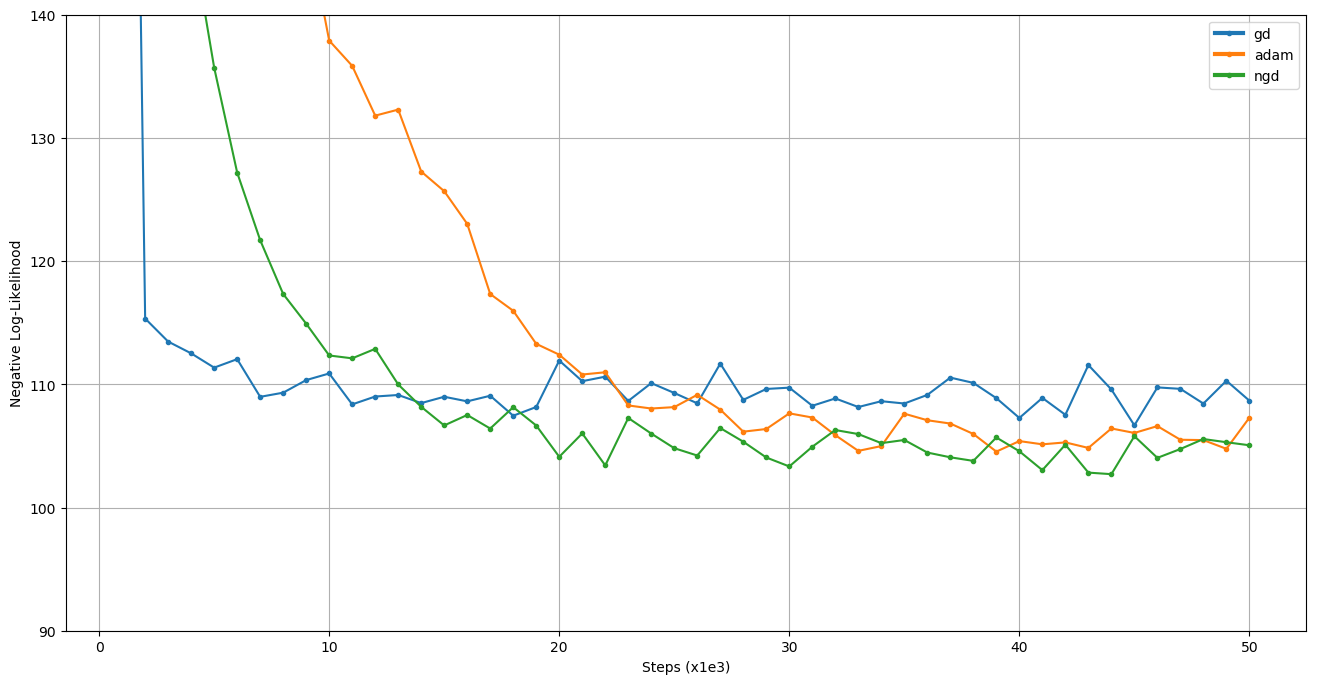

In [182]:
#saver = tf.train.Saver()

plt.style.use('default')
fig, ax = plt.subplots(1,1, figsize=(16,8))
plt.ylim(90,140)

plot_banded_error(sgd, "gd")
plot_banded_error(adm, "adam")
plot_banded_error(nsgd, "ngd")

fatlegend(ax)
plt.ylabel("Negative Log-Likelihood")
plt.xlabel("Steps (x1e3)")
ax.grid(True)
plt.show()
#fig.savefig('ns.png')

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
up = np.concatenate([j for j in [np.reshape(i,[14,28]) for i in result[2]]], 1)
dw = np.concatenate([j for j in [np.reshape(i,[14,28]) for i in result[3]]], 1)
p1 = np.concatenate(np.split(np.concatenate([up,dw], 0), batch_size/10, 1), 0)
dwy = np.concatenate([j for j in [np.reshape(i,[14,28]) for i in result[4]]], 1)
p2 = np.concatenate(np.split(np.concatenate([up,dwy], 0), batch_size/10, 1), 0)
ax[0].imshow(p1, cmap=plt.cm.gray, interpolation='none')
ax[1].imshow(p2, cmap=plt.cm.gray, interpolation='none')
ax[0].grid(False)
ax[1].grid(False)
plt.show()

In [21]:
def det_pass(inputs, layer, n, _expect, w1, w2):
    if layer==1:
        inputs = tf.nn.sigmoid(tf.matmul(inputs,w1[0])+w1[1])
    z = prob(tf.nn.sigmoid(tf.matmul(inputs,w2[0])+w2[1]), tf.tile(y_,[n,1]))
    return tf.reduce_sum(z/tf.stop_gradient(tf.tile(-_expect-eps,[n,1])), 1, keep_dims=True)

def muProp(p, s, layer, _expect, linear, w1, w2, w3):
    fh = det_pass(p, layer, ns**(layer-1), prob(_expect, y_), w2, w3)
    dfh = tf.gradients(fh, p)[0]
    mg = tf.stop_gradient(dfh)*p
    fh, dfh, p = [tf.tile(z, [ns,1]) for z in [fh, dfh, p]]
    g = fh+tf.reduce_sum(dfh*(s-p), 1, keep_dims=True)
    
    w = w1 if layer==1 else w2
    dg, dmg = [tf.gradients(tf.reduce_mean(z, 0), w)
               for z in [tf.stop_gradient(g)*log_prob(p, s), mg]]
    for i in range(2):
        dg[i] = dg[i]-dmg[i] if linear else dmg[i]/(dg[i]+eps)
    return dg

cv2 = muProp(h2, sh2, 2, y_expect, linear,
             get_weights("wxh"), get_weights("whh"), get_weights("why"))
cv  = muProp(h, sh, 1, y_expect, linear,
             get_weights("wxh"), get_weights("whh"), get_weights("why"))

mpgd = [list(i) for i in dy]+[list(i) for i in dh2]+[list(i) for i in dh]
for i in range(2):
    if linear:
        mpgd[i+2][0] -= cv2[i]
        mpgd[i+4][0] -= cv[i]
    else:
        mpgd[i+2][0] *= cv2[i]
        mpgd[i+4][0] *= cv[i]
        
mptrain_step = opt.apply_gradients(mpgd)

In [22]:
lh = tf.nn.sigmoid(tf.matmul(x, _wxh)+_bxh)
lh2 = tf.nn.sigmoid(tf.matmul(sh, _whh)+_bhh)
ly  = tf.nn.sigmoid(tf.matmul(sh2,_why)+_bhy)
ly_expect = tf.reduce_mean(tf.reshape(ly, [ns**2, -1, 392]), 0)

lnll = tf.reduce_mean(tf.reduce_sum(-log_prob(ly_expect, y_), 1))
lls2 = tf.reduce_sum(prob(ly, tf.tile(y_,[ns**2,1]))/
                     tf.stop_gradient(tf.tile(-prob(ly_expect, y_)-eps, [ns**2,1])), 1, keep_dims=True)
lls = tf.reduce_mean(tf.reshape(lls2, [ns,-1,1]), 0)

_lh, _lh2 = [tf.tile(z, [ns, 1]) for z in [lh, lh2]]
ldh2 = tf.gradients(tf.reduce_mean(tf.stop_gradient(lls2)*log_prob(_lh2, sh2), 0), [_whh, _bhh])
ldh  = tf.gradients(tf.reduce_mean(tf.stop_gradient(lls)*log_prob(_lh, sh), 0),[_wxh, _bxh])

lcv2 = muProp(lh2, sh2, 2, ly_expect, linear, [_wxh, _bxh], [_whh, _bhh], [_why, _bhy])
lcv = muProp(lh, sh, 1, ly_expect, linear,  [_wxh, _bxh], [_whh, _bhh], [_why, _bhy])

lgd = [list(i) for i in dy]+[list(i) for i in dh2]+[list(i) for i in dh]
for i in range(2):
    if linear:
        lgd[i+2][0] -= cv2[i]
        lgd[i+4][0] -= cv[i]
        ldh2[i] -= lcv2[i]
        ldh[i] -= lcv[i]
    else:
        lgd[i+2][0] *= cv2[i]
        lgd[i+4][0] *= cv[i]  
        ldh2[i] *= lcv2[i]
        ldh[i] *= lcv[i]        

if linear:
    lgd[2][0] -= ldh2[0] - gd_whh
    lgd[3][0] -= ldh2[1] - gd_bhh
    lgd[4][0] -= ldh[0] - gd_wxh
    lgd[5][0] -= ldh[1] - gd_bxh
else:
    lgd[2][0] *= gd_whh / (ldh2[0]+eps)
    lgd[3][0] *= gd_bhh / (ldh2[1]+eps)
    lgd[4][0] *= gd_wxh / (ldh[0]+eps)
    lgd[5][0] *= gd_bxh / (ldh[1]+eps)
    
ltrain_step = opt.apply_gradients(lgd)

### Gradient estimators

In [ ]:
bsln = tf.placeholder(tf.float32)
bslnv = tf.placeholder(tf.float32)
opt = tf.train.AdamOptimizer(lr)

def gd_est(md, linear, cf, sta, nn):
    func = {
        0: lambda p, s, layer, w, cf, nn: [tf.zeros([ns**layer*batch_size,1]), tf.zeros([1])],
        1: muProp,
        2: DARN,
        3: baseline,
        4: NVIL
    }
    g2, mg2 = func.get(md)(h2, sh2, 2, get_weights("whh", "bhh"), cf, nn)
    g, mg = func.get(md)(h, sh, 1, get_weights("wxh", "bxh"), cf, nn)
    f, f2 = ls, ls2
    m = g2
    v = tf.constant(0.)
    tr = None
    
    dy = opt.compute_gradients(nll, get_weights("why", "bhy"))    
    if linear:
        c2 = cv_coef(h2, nn, 2, get_weights("whh", "bhh")) if cf else tf.ones([batch_size*ns,1])        
        c = cv_coef(h, nn, 1, get_weights("wxh", "bxh")) if cf else tf.ones([batch_size,1])   
        dh2 = opt.compute_gradients(tf.reduce_mean(tf.stop_gradient(f2-tf.tile(c2,[ns,1])*g2)*log_prob(_h2, sh2), 0)+
                                    tf.reduce_mean(tf.stop_gradient(c2)*mg2, 0), get_weights("whh", "bhh"))        
        dh  = opt.compute_gradients(tf.reduce_mean(tf.stop_gradient(f-tf.tile(c,[ns,1])*g)*log_prob(_h, sh), 0)+
                                    tf.reduce_mean(tf.stop_gradient(c)*mg, 0), get_weights("wxh", "bxh"))
    else:
        dh2f, dh2g, dh2mg = [opt.compute_gradients(tf.reduce_mean(z, 0), get_weights("whh", "bhh"))
                             for z in [tf.stop_gradient(f2)*log_prob(_h2, sh2),
                                       tf.stop_gradient(g2)*log_prob(_h2, sh2), mg2]]
        dhf, dhg, dhmg = [opt.compute_gradients(tf.reduce_mean(z, 0), get_weights("wxh", "bxh"))
                          for z in [tf.stop_gradient(f)*log_prob(_h, sh),
                                    tf.stop_gradient(g)*log_prob(_h, sh), mg]]
        if cf:
            b2 = bias_cor(f2, g2, _h2, sh2, nn, 2, get_weights("whh", "bhh"), nh) 
            b = bias_cor(f, g, _h, sh, nn, 1, get_weights("wxh", "bxh"), 392)
        else:
            b2 = [tf.zeros([nh,nh]), tf.zeros([1,nh])]
            b = [tf.zeros([392,nh]), tf.zeros([1,nh])]
        
        dh2, dh = [list(z) for z in dh2f], [list(z) for z in dhf]
        for j in range(2):
            dh2[j][0] = (dh2[j][0]/(dh2g[j][0]+eps)-b2[j])*dh2mg[j][0]
            dh[j][0] = (dh[j][0]/(dhg[j][0]+eps)-b[j])*dhmg[j][0]

    gd = [list(i) for i in dy]+[list(i) for i in dh2]+[list(i) for i in dh]

    train_step = opt.apply_gradients(gd if tr is None else gd+tr)
    return train_step, y_expect, nll, m, v

def muProp(p, s, layer, w, cf, nn):
    fh = det_pass(p, layer, ns**(layer-1), prob(y_expect, y_))
    dfh = tf.gradients(fh, p)[0]
    mg = tf.stop_gradient(dfh)*p
    fh, dfh, p = [tf.tile(z, [ns,1]) for z in [fh, dfh, p]]
    g = fh+tf.reduce_sum(dfh*(s-p), 1, keep_dims=True)
    return g, mg

def cv_coef(p, nn, layer, w):
    p = tf.reshape(p, [ns**(layer-1), batch_size, nh])
    for i in range(ns**(layer-1)):
        pp = p[i]
        ss = tf.stop_gradient(tf.reshape(Bernoulli(probs=pp, dtype=tf.float32).sample(nn), 
                                         [nn*batch_size, nh]))
        sls, sls_expect = stc_pass(ss, layer, nn)
        fh = det_pass(pp, layer, 1, sls_expect)
        dfh = tf.gradients(fh, pp)[0]
        _fh, _dfh, _p = [tf.tile(z, [nn,1]) for z in [fh, dfh, pp]]
        f = tf.stop_gradient(sls)*log_prob(_p, ss)
        g = tf.stop_gradient(_fh+tf.reduce_sum(_dfh*(ss-_p), 1, keep_dims=True))*log_prob(_p, ss)
        _, _, cov, vg = fg_cov(f, g, w, nn)
        t = tf.tile([[tf.reduce_sum(cov)/(tf.reduce_sum(vg)+eps)]],[batch_size,1])
        coef = t if i==0 else tf.concat([coef, t], 0)
    return coef

def bias_cor(f, g, p, s, nn, layer, w, dim):
    ff, gg = [tf.stop_gradient(z)*log_prob(s, p) for z in [f,g]]
    _f, _g = [tf.reshape(z,[ns,ns**(layer-1)*batch_size,nh]) for z in [ff,gg]]
    for i in range(ns):
        df, dg = [tf.concat(tf.gradients(z[i], w), 0) for z in [_f, _g]]
        mfg, mg = [df/(dg+eps), dg] if i==0 else [mfg+df/(dg+eps), mg+dg]
        sfgg = df if i==0 else sfgg+df
    mg /= ns
    sfgg = (sfgg-mg*mfg)/(ns-1)
    b = sfgg/(mg+eps)
    return b[0:dim], b[dim]

def DARN(p, s, layer, w, cf, nn):
    # only work for one layer
    if layer==1:
        return muProp(p, s, layer, w, cf, nn)
    dh = tf.gradients(ls2, s)[0] 
    g = ls2 + dh*(.5-s)
    return g, tf.zeros([1])

def baseline(p, s, layer, w, cf, nn):
    b = alpha*bsln + (1.0-alpha)*tf.reduce_mean(ls)
    g = tf.stop_gradient(b)
    return g, tf.zeros([1])

def NVIL():
    ch = add_layer(x, "wh", "bh", 392, 100, tf.tanh)
    cy = add_layer(ch, "wy", "by", 100, 1)
    b = alpha*bsln + tf.reduce_mean((1.0-alpha)*(loss-cy))
    vv = tf.reduce_mean(tf.square(loss-cy-tf.reduce_mean(loss-cy)))/tf.maximum(1.0, (ns-1))
    v = alpha*bslnv + (1.0-alpha)*vv
    g = tf.stop_gradient((cy+b)/tf.maximum(1.0,tf.sqrt(v))) * p
    f = tf.stop_gradient(loss/tf.maximum(1.0,tf.sqrt(v))) * p
    tr = opt.compute_gradients(tf.reduce_mean(tf.square(tf.stop_gradient(loss-b)-cy)), 
                               [get_weights("wh", "bh", 392, 100), get_weights("wy", "by", 100, 1)])
    return f, g, None, tr, b, v

def ST_():
    train_step = tf.train.AdamOptimizer(lr).minimize(nll)
    return train_step, nll, tf.constant(0.), tf.constant(0.)

In [ ]:
steps = 50000
inner_steps = 1
level = False
ons = 4
ins = 64

with tf.Session() as sess:
    loss_rec = np.empty((1000, steps/1000))
    rand_rec = np.empty((1000, steps/1000))
    w1 = gdw1 = np.zeros([100,392])
    w2 = gdw2 = np.zeros([1, 392])
    w3 = gdw3 = np.zeros([100,100])
    w4 = gdw4 = np.zeros([1,100])
    w5 = gdw5 = np.zeros([392,100])
    w6 = gdw6 = np.zeros([1,100])
    
    sess.run(tf.global_variables_initializer())
          
    for i in range(steps):
        batch_   = data.next_batch(2, shuffle=True)[0]
        batch_xs = batch_[:, 0:392]
        batch_ys = batch_[:, 392:784]
        
        if level:
            res = sess.run([mpgd, mptrain_step], {x: batch_xs, y_: batch_ys, ns: ons, ilr: inner_steps,
                                    _why:   w1,   _bhy:   w2,   _whh:   w3,   _bhh:   w4,   _wxh:   w5,   _bxh:   w6,
                                    gd_why: gdw1, gd_bhy: gdw2, gd_whh: gdw3, gd_bhh: gdw4, gd_wxh: gdw5, gd_bxh: gdw6
                                   })
            gdw1, w1 = res[0][0][0], res[0][0][1] 
            gdw2, w2 = res[0][1][0], res[0][1][1] 
            gdw3, w3 = res[0][2][0], res[0][2][1] 
            gdw4, w4 = res[0][3][0], res[0][3][1] 
            gdw5, w5 = res[0][4][0], res[0][4][1] 
            gdw6, w6 = res[0][5][0], res[0][5][1]
            
        for j in range(inner_steps):
            res = sess.run([qq, mptrain_step, cr, nll],
                           {x: batch_xs, y_: batch_ys, ns: ins, ilr: inner_steps,
                              _why:   w1,   _bhy:   w2,   _whh:   w3,   _bhh:   w4,   _wxh:   w5,   _bxh:   w6,
                            gd_why: gdw1, gd_bhy: gdw2, gd_whh: gdw3, gd_bhh: gdw4, gd_wxh: gdw5, gd_bxh: gdw6
                           })

        loss_rec[i%1000, i/1000] = res[-1]
        rand_rec[i%1000, i/1000] = res[-2]
        if (i+1)%1000==0:
            print (i+1)/1000, np.mean(loss_rec[:, i/1000], 0), np.mean(rand_rec[:, i/1000], 0), res[0],

mpl64 = loss_rec
mplr64 = rand_rec
#np.save("dn_20_4.npy", dn_20_4)

In [ ]:
djx = tf.placeholder(tf.float32,[3,100,393])
djh = tf.placeholder(tf.float32,[3,100,101])
djy = tf.placeholder(tf.float32,[3,392,101])
it1 = tf.placeholder(tf.bool)

ngd = [list(i) for i in dh]+[list(i) for i in dh2]+[list(i) for i in dy]
layer = [[h, "wxh",[100,393],  dh[0][0],0,djx]]
#        [h2, "whh",[100,101], dh2[0][0],1,djh]]
#         [y, "why",[392,101],  dy[0][0],0,djy]]

for z in layer:
    J = tf.reshape(tf.gradients(z[0], get_weights(z[1]))[0], z[2])

    dJ = tf.cond(it1,
                 lambda: tf.square(J)/tf.transpose(z[0]*(1-z[0])+eps)+eps,
                 lambda:(tf.square(J)/tf.transpose(z[0]*(1-z[0])+eps)+eps)*.1+.9*z[5][0])
    rJ = tf.cond(it1,
                 lambda:J*tf.transpose([J[:,-1]])/tf.transpose(z[0]*(1-z[0])+eps),
                 lambda:J*tf.transpose([J[:,-1]])/tf.transpose(z[0]*(1-z[0])+eps)*.1+.9*z[5][1])
    
    u = tf.concat([rJ[:,0:-1]/dJ[:,0:-1], -1*tf.ones([tf.shape(rJ)[0],1])],1)
    rho = tf.transpose([1/((2-z[2][1])*dJ[:,-1])])

    gg = tf.cond(it1,
                 lambda: tf.reshape(z[3],z[2]),
                 lambda: tf.reshape(z[3],z[2]))#.9*z[5][2]+.1*tf.reshape(z[3],z[2]))
    
    ng = tf.concat([gg[:,0:-1]/dJ[:,0:-1], tf.zeros([tf.shape(gg)[0],1])],1)
    ng += tf.reduce_sum(u*gg,1,keep_dims=True)*u*rho        
    ngd[z[4]][0] = tf.check_numerics(tf.reshape(ng,[-1]), "!!!")
    
    if z[4]==0:
        xdj = tf.concat([tf.concat([[dJ],[rJ]],0),[gg]],0)
#    else:
#        hdj = tf.concat([tf.concat([[dJ],[rJ]],0),[gg]],0)
        
ntrain_step = opt.apply_gradients(ngd)